In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/Main_Data/Image/ADNI3/* .

In [ ]:
!cp -r /content/drive/MyDrive/Main_Data/Split/* .

In [ ]:
# !tar -xzf adni1_brain_resid.tar.gz

In [ ]:
# !tar -xzf adni1_brain_stand.tar.gz

In [ ]:
!cat adni3* | tar xzf -

## Load the images

In [ ]:
import nibabel as nib

In [ ]:
import glob

images = sorted(glob.glob('processed/**/*.nii.gz', recursive=True))

In [ ]:
import numpy as np

def check_files(files):
  corrupted = []

  for file_path in files:

    try:
      # Load the NIfTI file
      nifti_img = nib.load(file_path)

      # Get the image data and header
      img_data = nifti_img.get_fdata()

      img_header = nifti_img.header

    except Exception as e:
      corrupted.append(e)

  return corrupted


In [ ]:
# corrupted = check_files(images)

In [ ]:
# corrupted

In [ ]:
import re

def image_exists(sample):
  image_id, group = sample
  return image_id in id_to_path

def make_id_translator(paths):
  return {re.search('((I|D)\d{3,8})\.', x).group(1): x for x in paths}

def filter_missing_data(images, labels, existing_ids):

    zipped_set = list(zip(images, labels))

    zipped_set = list(filter(lambda x: image_exists(x, existing_ids), zipped_set))

    images, labels = zip(*zipped_set)

    return images, labels

id_to_path = make_id_translator(images)

# CNN - pretrain

## Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class Auto3dCNN11(nn.Module):
    def __init__(self, input_size=(182, 182, 218)): #input: (182, 182, 218)
        super(Auto3dCNN11, self).__init__()

        output_size = list(input_size)
        self.sizes = [[18, 18, 22], [37, 37, 44]]

        self.encoder = nn.Sequential()
        self.decoder = nn.Sequential()

        # Encoder

        self.encoder.append(nn.Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2)))
        self.encoder.append(nn.ReLU())
        self.encoder.append(nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        self.encoder.append(nn.Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.encoder.append(nn.ReLU())
        self.encoder.append(nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        self.encoder.append(nn.Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.encoder.append(nn.ReLU())

        # Decoder

        self.decoder.append(nn.ConvTranspose3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.decoder.append(nn.ReLU())
        self.decoder.append(nn.Upsample(size=self.sizes[0], mode='trilinear', align_corners=False))
        self.decoder.append(nn.ConvTranspose3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.decoder.append(nn.ReLU())
        self.decoder.append(nn.Upsample(size=self.sizes[1], mode='trilinear', align_corners=False))
        self.decoder.append(nn.ConvTranspose3d(32, 1, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2), output_padding=(1, 1, 2)))
        self.decoder.append(nn.Tanh())

    def forward(self, x):

        outputs = []
        for i, layer in enumerate(self.encoder):
          if i % 3 == 0: # convolution
            x = layer(x)
          elif i % 3 == 1: # activation
            x = layer(x)
            outputs.append(x)
          else: # upsample
            x = layer(x)

        out_i = len(outputs) - 1
        for i, layer in enumerate(self.decoder):
          if i % 3 == 0: # convolution
            x = x + outputs[out_i]
            x = layer(x)
            out_i -= 1
          elif i % 3 == 1: # activation
            x = layer(x)
          else: # upsample
            x = layer(x)
        return x


class ConvBlock11(nn.Module):

  def __init__(self):
    super(ConvBlock11, self).__init__()

    self.conv1 = nn.Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2))
    self.batch_norm1 = nn.BatchNorm3d(32)
    self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

    self.conv2 = nn.Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    self.batch_norm2 = nn.BatchNorm3d(16)
    self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

    self.conv3 = nn.Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    self.batch_norm3 = nn.BatchNorm3d(8)
    self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

  def forward(self, x):

    x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
    x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
    x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))

    return x


class FullNetwork11(nn.Module):

  def __init__(self, encoder, num_classes=3):
    super(FullNetwork11, self).__init__()

    self.encoder = encoder

    for param in list(self.encoder.parameters()):
        param.requires_grad = False

    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(8 * 4 * 4 * 5, 12)
    self.batch_norm_fc = nn.BatchNorm1d(12)
    self.fc2 = nn.Linear(12, num_classes)

  def forward(self, x):

    x = self.encoder(x)

    x = self.flatten(x)
    x = F.relu(self.batch_norm_fc(self.fc1(x)))
    x = self.fc2(x)

    return x


class TheActualGRU(nn.Module):

  def __init__(self, num_classes=3):
    super(TheActualGRU, self).__init__()

    self.bgru_1 = nn.GRU(640, 640, batch_first = True, bidirectional = True) # output: x: (N,L,2∗H_out), h_n: (2∗num_layers,N,H_out​)
    self.bgru_2 = nn.GRU(1280, 200, batch_first = True, bidirectional = True)
    self.dropout_1 = nn.Dropout(p = 0.2)
    self.bgru_3 = nn.GRU(400, 50, batch_first = True, bidirectional = True)
    self.fc1 = nn.Linear(100, 50)
    self.dropout_2 = nn.Dropout(p = 0.2)
    self.fc2 = nn.Linear(50, num_classes)

  def forward(self, x):
    # h0 = torch.zeros(2, x.size(0), 300).to(x.device) # defaults to zero if not provided

    x, _ = self.bgru_1(x)
    x, _ = self.bgru_2(x)
    x = self.dropout_1(x)
    x, _ = self.bgru_3(x)
    x = x[:, -1, :]
    x = self.fc1(x)
    x = self.dropout_2(x)
    x = self.fc2(x)

    return x


class CRNN(nn.Module):

  def __init__(self, tp0, tp1, tp2, tp3, tp4, tp5, bgru=None, num_classes=3):
    super(CRNN, self).__init__()

    self.tp0, self.tp1, self.tp2, self.tp3, self.tp4, self.tp5 = tp0, tp1, tp2, tp3, tp4, tp5

    if bgru is not None:
      self.bgru = bgru
    else:
      self.bgru = TheActualGRU(num_classes=3)

  def forward(self, x): # x: 4, 1, 6, 182, 218, 182

    tp0_out = self.tp0(x[:,:,0,:,:,:])
    tp1_out = self.tp1(x[:,:,1,:,:,:])
    tp2_out = self.tp2(x[:,:,2,:,:,:])
    tp3_out = self.tp3(x[:,:,3,:,:,:])
    tp4_out = self.tp4(x[:,:,4,:,:,:])
    tp5_out = self.tp5(x[:,:,5,:,:,:])

    t_out = torch.stack([tp0_out, tp1_out, tp2_out, tp3_out, tp4_out, tp5_out], dim=1)

    out = self.bgru(t_out)

    return out


### load pretrained

In [ ]:
import os
import shutil

def load_pretrained(filename='run_checkpoint.pth', num_classes=2):

  if num_classes == 2 or num_classes == 3:
    model = FullNetwork11(num_classes=num_classes)
  else:
    raise Exception('we can only classify for two or three classes')

  if not os.path.isfile(filename):
    shutil.copy(src = f'/content/drive/MyDrive/Main_Data/Checkpoints3/part2/augmented_timepoints/{filename}', dst='.')

  if not torch.cuda.is_available():
    checkpoint = torch.load(filename, map_location=torch.device('cpu'))
  else:
    checkpoint = torch.load(filename)

  try:

    model.load_state_dict(checkpoint['model_state_dict'], strict=True)

  except RuntimeError as re:

    old_state = checkpoint['model_state_dict']

    new_state = model.state_dict()

    assert len(old_state.keys()) == len(new_state.keys())

    new_to_old = {}
    for kn, ko in zip(new_state.keys(), old_state.keys()):
      new_to_old[kn] = ko

    for key, value in new_state.items():

      if 'encoder' in key:
        weights = old_state[key.replace('encoder.', '')]
      else:
        weights = old_state[key]

    model.load_state_dict(new_state, strict=True)

  for param in model.parameters():
      param.requires_grad = False

  for name, param in model.named_parameters():
      if '3' in name:
        param.requires_grad = True

  return model

def load_pretrained_timeless(filename='augmented_cnn11_adni3.pth', num_classes=2):

  if num_classes == 2 or num_classes == 3:
    model = FullNetwork11(num_classes=num_classes)
  else:
    raise Exception('we can only classify for two or three classes')

  savename = f'{num_classes}c_{filename}'

  if not os.path.isfile(savename):
    shutil.copy(src = f'/content/drive/MyDrive/Main_Data/Checkpoints3/part2/{savename}', dst='.')

  if not torch.cuda.is_available():
    checkpoint = torch.load(savename, map_location=torch.device('cpu'))
  else:
    checkpoint = torch.load(savename)

  try:

    model.load_state_dict(checkpoint['model_state_dict'], strict=True)

  except RuntimeError as re:

    old_state = checkpoint['model_state_dict']

    new_state = model.state_dict()

    assert len(old_state.keys()) == len(new_state.keys())

    new_to_old = {}
    for kn, ko in zip(new_state.keys(), old_state.keys()):
      new_to_old[kn] = ko

    for key, value in new_state.items():

      if 'encoder' in key:
        weights = old_state[key.replace('encoder.', '')]
      else:
        weights = old_state[key]

    model.load_state_dict(new_state, strict=True)

  for param in model.parameters():
      param.requires_grad = False

  for name, param in model.named_parameters():
      if '3' in name:
        param.requires_grad = True

  return model

In [ ]:
def load_whole_model(num_classes=2):

  # tp0 = load_pretrained(filename=f"{num_classes}c_timepoint-sc_cnn11_adni1.pth", num_classes=num_classes).encoder
  # tp1 = load_pretrained(filename=f"{num_classes}c_timepoint-m06_cnn11_adni1.pth", num_classes=num_classes).encoder
  # tp2 = load_pretrained(filename=f"{num_classes}c_timepoint-m12_cnn11_adni1.pth", num_classes=num_classes).encoder
  # tp3 = load_pretrained(filename=f"{num_classes}c_timepoint-m18_cnn11_adni1.pth", num_classes=num_classes).encoder
  # tp4 = load_pretrained(filename=f"{num_classes}c_timepoint-m24_cnn11_adni1.pth", num_classes=num_classes).encoder
  # tp5 = load_pretrained(filename=f"{num_classes}c_timepoint-m36_cnn11_adni1.pth", num_classes=num_classes).encoder

  tp0 = load_pretrained(filename=f"{num_classes}c_timepoint-sc_cnn11_adni3.pth", num_classes=num_classes).encoder
  tp1 = load_pretrained(filename=f"{num_classes}c_timepoint-y1_cnn11_adni3.pth", num_classes=num_classes).encoder
  tp2 = load_pretrained(filename=f"{num_classes}c_timepoint-y2_cnn11_adni3.pth", num_classes=num_classes).encoder
  tp3 = load_pretrained(filename=f"{num_classes}c_timepoint-y3_cnn11_adni3.pth", num_classes=num_classes).encoder
  tp4 = load_pretrained(filename=f"{num_classes}c_timepoint-y4_cnn11_adni3.pth", num_classes=num_classes).encoder
  tp5 = load_pretrained(filename=f"{num_classes}c_timepoint-y5_cnn11_adni3.pth", num_classes=num_classes).encoder

  if num_classes == 2 or num_classes == 3:
    model = CRNN(tp0, tp1, tp2, tp3, tp4, tp4, num_classes=num_classes)
  else:
    raise Exception('we can only classify for two or three classes')

  return model

def load_whole_model_timeless(num_classes=2):

  tp0 = load_pretrained_timeless(num_classes=num_classes).encoder
  tp1 = load_pretrained_timeless(num_classes=num_classes).encoder
  tp2 = load_pretrained_timeless(num_classes=num_classes).encoder
  tp3 = load_pretrained_timeless(num_classes=num_classes).encoder
  tp4 = load_pretrained_timeless(num_classes=num_classes).encoder
  tp5 = load_pretrained_timeless(num_classes=num_classes).encoder

  if num_classes == 2 or num_classes == 3:
    model = CRNN(tp0, tp1, tp2, tp3, tp4, tp4, num_classes=num_classes)
  else:
    raise Exception('we can only classify for two or three classes')

  return model

In [ ]:
from torchsummary import summary

In [ ]:
summary(load_whole_model_timeless(num_classes=2), (1, 6, 182, 218, 182), device='cpu')

## dataset creation

In [ ]:
import pandas as pd

tuning_df = pd.read_csv('ADNI3_tune.csv').drop('Unnamed: 0', axis=1)
testing_df = pd.read_csv('ADNI3_test.csv').drop('Unnamed: 0', axis=1)

In [ ]:
tuning_df = tuning_df[tuning_df['Image Data ID'].isin(id_to_path)]
testing_df = testing_df[testing_df['Image Data ID'].isin(id_to_path)]

In [ ]:
## only run if you're using adni3

def replace_init(row):
  if row['Visit'] == 'init':
    return 'sc'
  else:
    return row['Visit']

tuning_df['Visit'] = tuning_df.apply(replace_init, axis=1)
testing_df['Visit'] = testing_df.apply(replace_init, axis=1)

In [ ]:
## if two classes:
tuning_df = tuning_df[tuning_df['Group'] != 'MCI']
testing_df = testing_df[testing_df['Group'] != 'MCI']

In [ ]:
from sklearn.model_selection import train_test_split

Subjects, Groups = tuning_df[['Subject', 'Group']].drop_duplicates(['Subject']).T.to_numpy()
train_subjects, valid_subjects = train_test_split(Subjects, test_size=0.11, random_state=22, stratify=Groups)


In [ ]:
def reorder_images(group, dset='adni3'):
    if dset == 'adni1':
        order_mapping = {'sc': 0, 'm06': 1, 'm12': 2, 'm18': 3, 'm24': 4, 'm36': 5}
    else:
        order_mapping = {'sc': 0, 'y1': 1, 'y2': 2, 'y3': 3, 'y4': 4, 'y5': 5}
    result = [None] * 6
    for index, row in group.iterrows():
        result[order_mapping[row['Visit']]] = row['Image Data ID']
    return result

In [ ]:
def id_to_path_with_none(id):
  if id is None:
    return None
  return id_to_path[id]

In [ ]:
train_imagelist = tuning_df[tuning_df['Subject'].isin(train_subjects)].groupby('Subject')[['Visit', 'Image Data ID']].apply(reorder_images).rename('ImageIDs')
train_df = tuning_df[['Subject', 'Group']].drop_duplicates(['Subject']).merge(train_imagelist, left_on='Subject',right_index=True)[['ImageIDs', 'Group']]
train_imagelist, train_labels = train_df.T.to_numpy()
train_image_paths = [[id_to_path_with_none(id) for id in sbj_list] for sbj_list in train_imagelist]

In [ ]:
valid_imagelist = tuning_df[tuning_df['Subject'].isin(valid_subjects)].groupby('Subject')[['Visit', 'Image Data ID']].apply(reorder_images).rename('ImageIDs')
valid_df = tuning_df[['Subject', 'Group']].drop_duplicates(['Subject']).merge(valid_imagelist, left_on='Subject',right_index=True)[['ImageIDs', 'Group']]
valid_imagelist, valid_labels = valid_df.T.to_numpy()
valid_image_paths = [[id_to_path_with_none(id) for id in sbj_list] for sbj_list in valid_imagelist]

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import nibabel as nib
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
from torch.utils.data import WeightedRandomSampler, RandomSampler


class CRNNDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path_list = self.file_paths[idx]
        label = self.labels[idx]

        images = []

        for file_path in file_path_list:

          if file_path is None:
            none_img = np.ones((182,218,182)) * -1
            images.append(none_img)
            continue

          # Load NIfTI image
          nifti_img = nib.load(file_path)

          # Get the image data
          img_data = nifti_img.get_fdata()

          # Assuming the data is in a reasonable range, you may normalize it
          max_i = img_data.max()
          min_i = img_data.min()
          img_data = (img_data - min_i) / (max_i - min_i)

          images.append(img_data)

        stacked_images = np.stack(images, axis=0)

        # Expand dimensions to add a channel (assuming grayscale images)
        img_data = np.expand_dims(stacked_images, axis=0)

        # Permute dimensions to match [batch_size, channels, depth, height, width]
        # (182, 218, 182) -> (182, 182, 218)
        img_data = torch.FloatTensor(img_data).permute(0, 1, 4, 2, 3)

        if self.transform:
            img_data = self.transform(img_data)

        return img_data, torch.FloatTensor(label)


# Convert labels to one-hot encoding
le = LabelEncoder()
y_train_encoded = le.fit_transform(train_labels)
y_valid_encoded = le.transform(valid_labels)
n_classes = len(le.classes_)


y_train_one_hot = torch.nn.functional.one_hot(torch.tensor(y_train_encoded), num_classes=n_classes).float()
y_valid_one_hot = torch.nn.functional.one_hot(torch.tensor(y_valid_encoded), num_classes=n_classes).float()

# Create custom datasets
train_dataset = CRNNDataset(file_paths=train_image_paths, labels=y_train_one_hot)
valid_dataset = CRNNDataset(file_paths=valid_image_paths, labels=y_valid_one_hot)

batch_size = 8
num_workers = 8
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)



In [ ]:
n_classes

2

In [ ]:
len(train_loader)

69

In [ ]:
len(valid_loader)

9

## create weights for weighted cost funciton

In [ ]:
total_learning_samples = len(train_dataset)
weights = [total_learning_samples / (n_classes * np.count_nonzero(y_train_encoded == i)) for i in range(n_classes)]

In [ ]:
weights = torch.tensor(weights)

## training

In [ ]:
import shutil
import os
from torch.utils.tensorboard import SummaryWriter

In [ ]:
def save_checkpoint(filename, epoch, model, optimizer, train_losses, test_losses, scheduler=None, early_stopper=None):

    save_path = '/content/drive/MyDrive/Main_Data/Checkpoints3/part3' # outsource the timepoint

    if not os.path.isdir(save_path):
      os.makedirs(save_path)

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'test_losses': test_losses
    }

    if scheduler is not None:
        checkpoint['scheduler'] = scheduler.state_dict()

    if early_stopper is not None:
        checkpoint['early_stopper'] = early_stopper.state_dict()

    torch.save(checkpoint, filename)
    shutil.copyfile(filename, os.path.join(save_path, filename))

def load_checkpoint(filename, model, optimizer, scheduler=None, early_stopper=None):

    if not torch.cuda.is_available():
      checkpoint = torch.load(filename, map_location=torch.device('cpu'))
    else:
      checkpoint = torch.load(filename)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']

    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler'])

    if early_stopper is not None:
        early_stopper.load_state_dict(checkpoint['early_stopper'])

    return epoch, train_losses, test_losses


In [ ]:
from typing import Dict, Any
from typing_extensions import TypeAlias
StateDict: TypeAlias = Dict[str, Any]

class StateDictAttributeError(AttributeError):

  def __init__(self, attribute_name):
    super().__init__(f"your state_dict lacks the parameter \"{attribute_name}\".")


class EarlyStopper:

    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def state_dict(self):
      return {"patience": self.patience, "min_delta": self.min_delta, "counter": self.counter, "min_validation_loss": self.min_validation_loss}

    def load_state_dict(self, state_dict: StateDict):

      if "patience" in state_dict:
        self.patience = state_dict["patience"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"patience\".")

      if "min_delta" in state_dict:
        self.min_delta = state_dict["min_delta"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"min_delta\".")

      if "counter" in state_dict:
        self.counter = state_dict["counter"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"counter\".")

      if "min_validation_loss" in state_dict:
        self.min_validation_loss = state_dict["min_validation_loss"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"min_validation_loss\".")


In [ ]:
def get_confusion_matrix(y_true, y_pred, classes):
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                      columns = [i for i in classes])
  return df_cm

In [ ]:
params_filename = '2c_crnn_timepoints_new_weighted_adni3.pth'

In [ ]:
import torch
import torch.optim as optim
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, f1_score

classes = le.classes_
n_classes = len(classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Instantiate the model
model = load_whole_model(num_classes=2)
model.to(device)

# Number of training epochs
num_epochs = 20

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=2e-5) #lr=0.001
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=1.0, total_iters=num_epochs)
early_stopper = EarlyStopper(patience=3, min_delta=0.01)

s_epoch = -1

# Initialize the loss arrays
train_losses = []
valid_losses = []

# Load the training data if needed
if os.path.isfile(params_filename):
  s_epoch, train_losses, valid_losses = load_checkpoint(params_filename, model, optimizer, scheduler, early_stopper)

# Training loop
for epoch in range(s_epoch + 1, num_epochs):

    # Training step
    model.train()

    y_true_train = []
    y_pred_train = []
    epoch_train_loss = 0

    print(f'Epoch {epoch}:')
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
    # for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate the loss
        loss = criterion(output, target)
        epoch_train_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        y_true_train.extend(torch.argmax(target, dim=1).cpu().numpy())
        y_pred_train.extend(torch.argmax(output, dim=1).cpu().numpy())


    # Training metrics
    epoch_train_loss = epoch_train_loss / len(train_loader)
    print(f'Training Loss: {epoch_train_loss:.4f}')

    train_accuracy = np.sum(np.array(y_true_train) == np.array(y_pred_train)) / len(y_true_train)
    print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

    train_f1 = f1_score(y_true_train, y_pred_train, average='weighted')
    print(f'Training F1-Score: {train_f1 * 100:.2f}%')

    df_cm_train = get_confusion_matrix(y_true_train, y_pred_train, classes)
    print(df_cm_train)


    # Validation step
    model.eval()

    epoch_valid_loss = 0
    y_true_valid = []
    y_pred_valid = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            epoch_valid_loss += loss.item()
            y_true_valid.extend(torch.argmax(target, dim=1).cpu().numpy())
            y_pred_valid.extend(torch.argmax(output, dim=1).cpu().numpy())


    # Validation metrics
    epoch_valid_loss = epoch_valid_loss / len(valid_loader) # not accurate, needs weighting (in loop multiply by minibatch size, outside divide by length of dataset)
    print(f'Validation Loss: {epoch_valid_loss:.4f}')

    valid_accuracy = np.sum(np.array(y_true_valid) == np.array(y_pred_valid)) / len(y_true_valid)
    print(f'Validation Accuracy: {valid_accuracy * 100:.2f}%')

    valid_f1 = f1_score(y_true_valid, y_pred_valid, average='weighted')
    print(f'Validation F1-Score: {valid_f1 * 100:.2f}%')

    df_cm_valid = get_confusion_matrix(y_true_valid, y_pred_valid, classes)
    print(df_cm_valid)


    # Summing up the epoch
    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_valid_loss)

    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print("Epoch %d: SGD lr %.6f -> %.6f" % (epoch, before_lr, after_lr))

    print(f'Epoch {epoch}: saving...')
    save_checkpoint(params_filename, epoch, model, optimizer, train_losses, valid_losses, scheduler=scheduler, early_stopper=early_stopper)

    # Check for early stopping possiblity
    if early_stopper.early_stop(epoch_valid_loss):
      print('Exitting this epoch early...')
      break

Epoch 0:


  0%|          | 0/69 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7be78483c700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7be78483c700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tor

Training Loss: 0.6641
Training Accuracy: 44.87%
Training F1-Score: 52.52%
          AD        CN
AD  0.735294  0.264706
CN  0.592050  0.407950


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6571
Validation Accuracy: 39.71%
Validation F1-Score: 44.60%
          AD        CN
AD  1.000000  0.000000
CN  0.694915  0.305085
Epoch 0: SGD lr 0.000020 -> 0.000020
Epoch 0: saving...
Epoch 1:


  0%|          | 0/69 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.6407
Training Accuracy: 50.92%
Training F1-Score: 58.31%
          AD        CN
AD  0.808824  0.191176
CN  0.533473  0.466527


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6117
Validation Accuracy: 44.12%
Validation F1-Score: 49.81%
          AD        CN
AD  1.000000  0.000000
CN  0.644068  0.355932
Epoch 1: SGD lr 0.000020 -> 0.000020
Epoch 1: saving...
Epoch 2:


  0%|          | 0/69 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.6157
Training Accuracy: 53.48%
Training F1-Score: 60.73%
          AD        CN
AD  0.823529  0.176471
CN  0.506276  0.493724


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.5950
Validation Accuracy: 41.18%
Validation F1-Score: 46.38%
          AD        CN
AD  1.000000  0.000000
CN  0.677966  0.322034
Epoch 2: SGD lr 0.000020 -> 0.000020
Epoch 2: saving...
Epoch 3:


  0%|          | 0/69 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.6080
Training Accuracy: 53.85%
Training F1-Score: 60.92%
          AD        CN
AD  0.882353  0.117647
CN  0.510460  0.489540


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.5764
Validation Accuracy: 44.12%
Validation F1-Score: 49.81%
          AD        CN
AD  1.000000  0.000000
CN  0.644068  0.355932
Epoch 3: SGD lr 0.000020 -> 0.000020
Epoch 3: saving...
Epoch 4:


  0%|          | 0/69 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5949
Training Accuracy: 52.38%
Training F1-Score: 59.46%
          AD        CN
AD  0.897059  0.102941
CN  0.529289  0.470711


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.5347
Validation Accuracy: 44.12%
Validation F1-Score: 49.81%
          AD        CN
AD  1.000000  0.000000
CN  0.644068  0.355932
Epoch 4: SGD lr 0.000020 -> 0.000020
Epoch 4: saving...
Epoch 5:


  0%|          | 0/69 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5945
Training Accuracy: 59.52%
Training F1-Score: 66.33%
          AD        CN
AD  0.735294  0.264706
CN  0.424686  0.575314


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.5595
Validation Accuracy: 44.12%
Validation F1-Score: 49.81%
          AD        CN
AD  1.000000  0.000000
CN  0.644068  0.355932
Epoch 5: SGD lr 0.000020 -> 0.000020
Epoch 5: saving...
Epoch 6:


  0%|          | 0/69 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5749
Training Accuracy: 54.21%
Training F1-Score: 61.27%
          AD        CN
AD  0.882353  0.117647
CN  0.506276  0.493724


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.5009
Validation Accuracy: 48.53%
Validation F1-Score: 54.67%
         AD       CN
AD  1.00000  0.00000
CN  0.59322  0.40678
Epoch 6: SGD lr 0.000020 -> 0.000020
Epoch 6: saving...
Epoch 7:


  0%|          | 0/69 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5693
Training Accuracy: 57.33%
Training F1-Score: 64.15%
          AD        CN
AD  0.897059  0.102941
CN  0.472803  0.527197


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.4888
Validation Accuracy: 70.59%
Validation F1-Score: 75.29%
          AD        CN
AD  0.888889  0.111111
CN  0.322034  0.677966
Epoch 7: SGD lr 0.000020 -> 0.000020
Epoch 7: saving...
Epoch 8:


  0%|          | 0/69 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5646
Training Accuracy: 62.82%
Training F1-Score: 69.12%
          AD        CN
AD  0.779412  0.220588
CN  0.393305  0.606695


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.5393
Validation Accuracy: 44.12%
Validation F1-Score: 49.81%
          AD        CN
AD  1.000000  0.000000
CN  0.644068  0.355932
Epoch 8: SGD lr 0.000020 -> 0.000020
Epoch 8: saving...
Epoch 9:


  0%|          | 0/69 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5456
Training Accuracy: 57.69%
Training F1-Score: 64.54%
          AD        CN
AD  0.867647  0.132353
CN  0.464435  0.535565


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.4754
Validation Accuracy: 75.00%
Validation F1-Score: 78.86%
          AD        CN
AD  0.888889  0.111111
CN  0.271186  0.728814
Epoch 9: SGD lr 0.000020 -> 0.000020
Epoch 9: saving...
Epoch 10:


  0%|          | 0/69 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5664
Training Accuracy: 65.20%
Training F1-Score: 71.10%
          AD        CN
AD  0.750000  0.250000
CN  0.361925  0.638075


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.4715
Validation Accuracy: 83.82%
Validation F1-Score: 85.85%
          AD        CN
AD  0.888889  0.111111
CN  0.169492  0.830508
Epoch 10: SGD lr 0.000020 -> 0.000020
Epoch 10: saving...
Epoch 11:


  0%|          | 0/69 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5355
Training Accuracy: 61.36%
Training F1-Score: 67.80%
          AD        CN
AD  0.867647  0.132353
CN  0.422594  0.577406


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.4919
Validation Accuracy: 51.47%
Validation F1-Score: 57.75%
          AD        CN
AD  1.000000  0.000000
CN  0.559322  0.440678
Epoch 11: SGD lr 0.000020 -> 0.000020
Epoch 11: saving...
Epoch 12:


  0%|          | 0/69 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.5056
Training Accuracy: 66.85%
Training F1-Score: 72.48%
          AD        CN
AD  0.867647  0.132353
CN  0.359833  0.640167


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.4618
Validation Accuracy: 73.53%
Validation F1-Score: 77.68%
          AD        CN
AD  0.888889  0.111111
CN  0.288136  0.711864
Epoch 12: SGD lr 0.000020 -> 0.000020
Epoch 12: saving...
Epoch 13:


  0%|          | 0/69 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.4991
Training Accuracy: 72.16%
Training F1-Score: 76.76%
          AD        CN
AD  0.823529  0.176471
CN  0.292887  0.707113


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.5511
Validation Accuracy: 47.06%
Validation F1-Score: 53.08%
          AD        CN
AD  1.000000  0.000000
CN  0.610169  0.389831
Epoch 13: SGD lr 0.000020 -> 0.000020
Epoch 13: saving...
Epoch 14:


  0%|          | 0/69 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.4802
Training Accuracy: 72.16%
Training F1-Score: 76.82%
          AD        CN
AD  0.897059  0.102941
CN  0.303347  0.696653


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.5627
Validation Accuracy: 51.47%
Validation F1-Score: 57.75%
          AD        CN
AD  1.000000  0.000000
CN  0.559322  0.440678
Epoch 14: SGD lr 0.000020 -> 0.000020
Epoch 14: saving...
Epoch 15:


  0%|          | 0/69 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.4394
Training Accuracy: 77.11%
Training F1-Score: 80.66%
          AD        CN
AD  0.838235  0.161765
CN  0.238494  0.761506


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.4590
Validation Accuracy: 85.29%
Validation F1-Score: 86.37%
          AD        CN
AD  0.666667  0.333333
CN  0.118644  0.881356
Epoch 15: SGD lr 0.000020 -> 0.000020
Epoch 15: saving...
Epoch 16:


  0%|          | 0/69 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.3797
Training Accuracy: 83.70%
Training F1-Score: 85.99%
          AD        CN
AD  0.941176  0.058824
CN  0.177824  0.822176


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.5935
Validation Accuracy: 52.94%
Validation F1-Score: 59.24%
          AD        CN
AD  1.000000  0.000000
CN  0.542373  0.457627
Epoch 16: SGD lr 0.000020 -> 0.000020
Epoch 16: saving...
Epoch 17:


  0%|          | 0/69 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.3604
Training Accuracy: 83.52%
Training F1-Score: 85.76%
          AD        CN
AD  0.897059  0.102941
CN  0.173640  0.826360


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.9265
Validation Accuracy: 73.53%
Validation F1-Score: 74.62%
          AD        CN
AD  0.111111  0.888889
CN  0.169492  0.830508
Epoch 17: SGD lr 0.000020 -> 0.000020
Epoch 17: saving...
Epoch 18:


  0%|          | 0/69 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.3385
Training Accuracy: 83.88%
Training F1-Score: 86.08%
          AD        CN
AD  0.911765  0.088235
CN  0.171548  0.828452


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.7466
Validation Accuracy: 76.47%
Validation F1-Score: 78.78%
          AD        CN
AD  0.444444  0.555556
CN  0.186441  0.813559
Epoch 18: SGD lr 0.000020 -> 0.000020
Epoch 18: saving...
Exitting this epoch early...


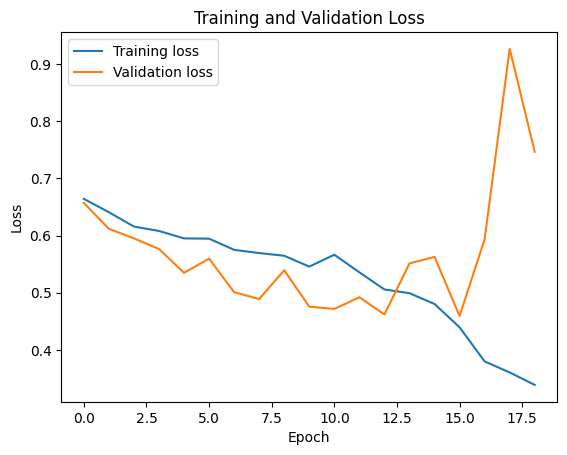

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()